<a href="https://www.kaggle.com/code/averma111/pytorch-timeseries-raytune?scriptVersionId=136497878" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [203]:
import warnings
import numpy as np
import pandas as pd
import copy
from pathlib import Path
import torch

from ray import tune
from ray.air import session
from ray.air.checkpoint import Checkpoint
from ray.tune.schedulers import ASHAScheduler

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [204]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/playground-series-s3e19/sample_submission.csv
/kaggle/input/playground-series-s3e19/train.csv
/kaggle/input/playground-series-s3e19/test.csv


In [205]:
train = pd.read_csv("/kaggle/input/playground-series-s3e19/train.csv")
train['date'] = pd.to_datetime(train['date'], errors='coerce')
train['year'] = train['date'].dt.year
train['month'] = train['date'].dt.month
train['day'] = train['date'].dt.day
train['quarter'] = train['date'].dt.quarter
train['weekday'] = train['date'].dt.weekday
train.head()


,id,date,country,store,product,num_sold,year,month,day,quarter,weekday
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63,2017,1,1,1,6
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66,2017,1,1,1,6
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9,2017,1,1,1,6
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59,2017,1,1,1,6
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49,2017,1,1,1,6


In [206]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        136950 non-null  int64         
 1   date      136950 non-null  datetime64[ns]
 2   country   136950 non-null  object        
 3   store     136950 non-null  object        
 4   product   136950 non-null  object        
 5   num_sold  136950 non-null  int64         
 6   year      136950 non-null  int64         
 7   month     136950 non-null  int64         
 8   day       136950 non-null  int64         
 9   quarter   136950 non-null  int64         
 10  weekday   136950 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 11.5+ MB


In [207]:
product_by_sold=train.groupby(['product'])['num_sold'].sum().reset_index()
product_by_sold

,product,num_sold
0,Using LLMs to Improve Your Coding,6069281
1,Using LLMs to Train More LLMs,5993975
2,Using LLMs to Win Friends and Influence People,932564
3,Using LLMs to Win More Kaggle Competitions,5068313
4,Using LLMs to Write Better,4604192


In [208]:
store_by_sold=train.groupby(['store'])['num_sold'].sum().reset_index()
store_by_sold

,store,num_sold
0,Kagglazon,15661335
1,Kaggle Learn,2755934
2,Kaggle Store,4251056


In [209]:
country_by_sold=train.groupby(['country'])['num_sold'].sum().reset_index()
country_by_sold

,country,num_sold
0,Argentina,1683244
1,Canada,7013114
2,Estonia,3577319
3,Japan,6013786
4,Spain,4380862


In [210]:
date_by_sold=train.groupby(['date'])['num_sold'].sum().reset_index()
date_by_sold

,date,num_sold
0,2017-01-01,20086
1,2017-01-02,15563
2,2017-01-03,15039
3,2017-01-04,14516
4,2017-01-05,14083
...,...,...
1821,2021-12-27,16724
1822,2021-12-28,18507
1823,2021-12-29,20110
1824,2021-12-30,20156


In [211]:
year_by_sold=train.groupby(['year'])['num_sold'].sum().reset_index()
year_by_sold

,year,num_sold
0,2017,4451213
1,2018,4723963
2,2019,4522172
3,2020,4086498
4,2021,4884479


In [212]:
month_by_sold=train.groupby(['month'])['num_sold'].sum().reset_index()
month_by_sold

,month,num_sold
0,1,2042783
1,2,1782267
2,3,1905982
3,4,1764963
4,5,1866246
5,6,1779787
6,7,1858402
7,8,1867996
8,9,1833097
9,10,1924133


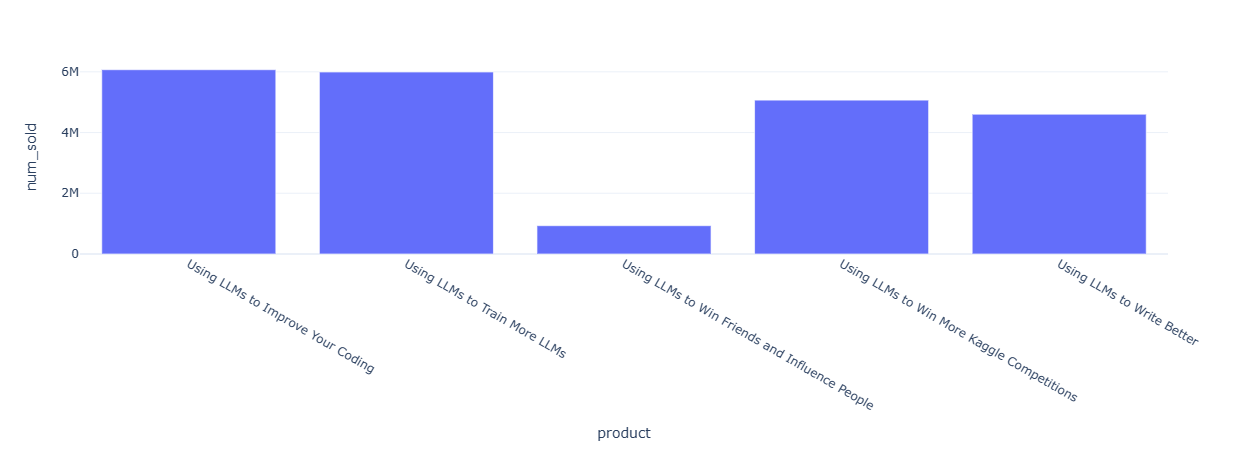

In [213]:
fig = px.bar(product_by_sold,x='product',y='num_sold')
fig.show()

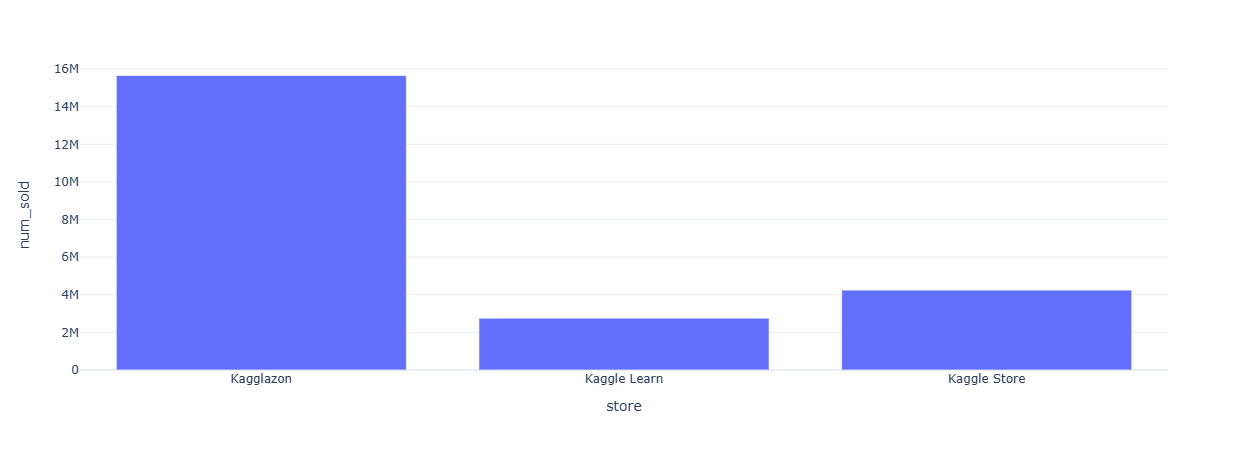

In [214]:
fig = px.bar(store_by_sold,x='store',y='num_sold')
fig.show()

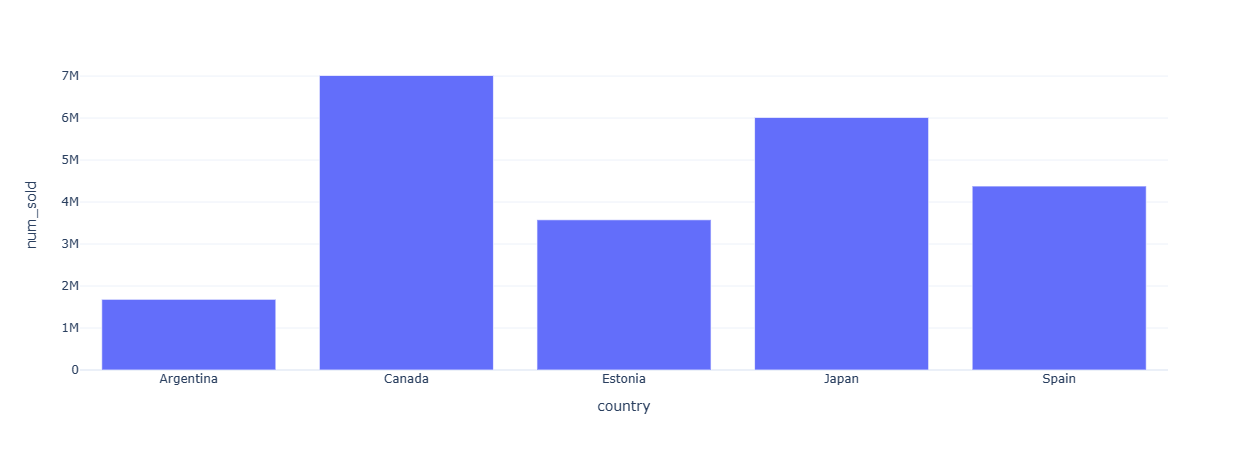

In [215]:
fig = px.bar(country_by_sold,x='country',y='num_sold')
fig.show()

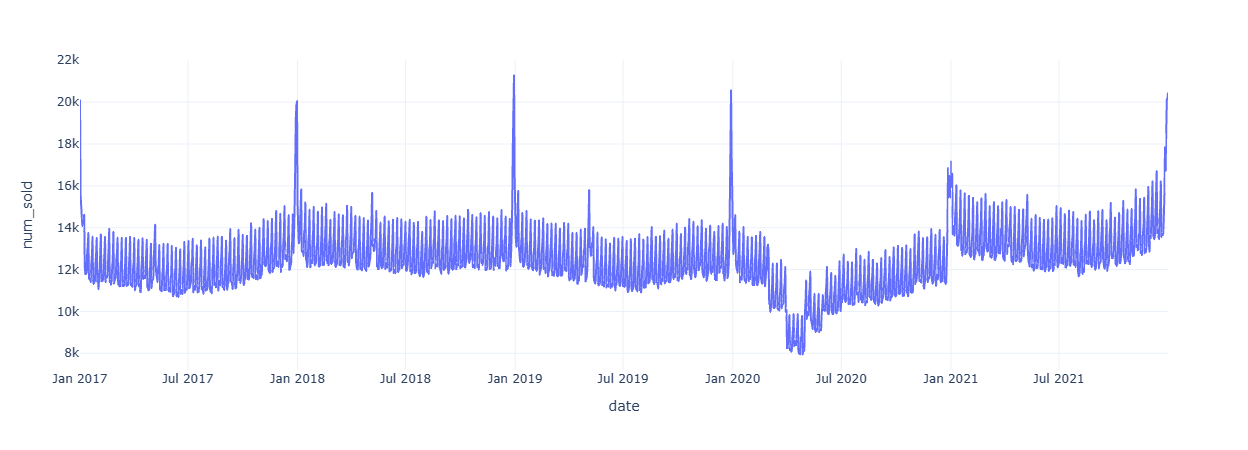

In [216]:
fig = px.line(date_by_sold,x='date',y='num_sold')
fig.show()

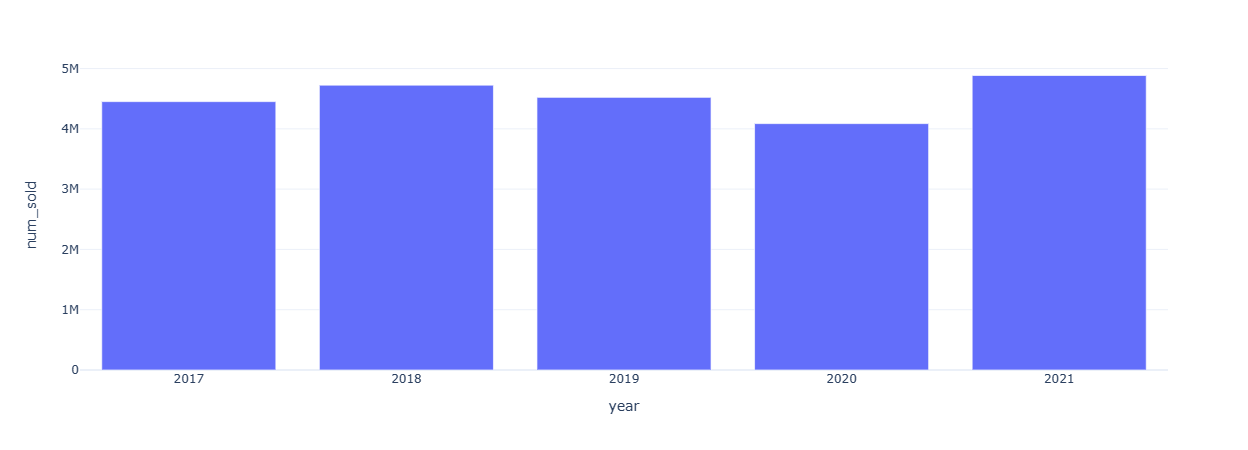

In [217]:
fig = px.bar(year_by_sold,x='year',y='num_sold')
fig.show()

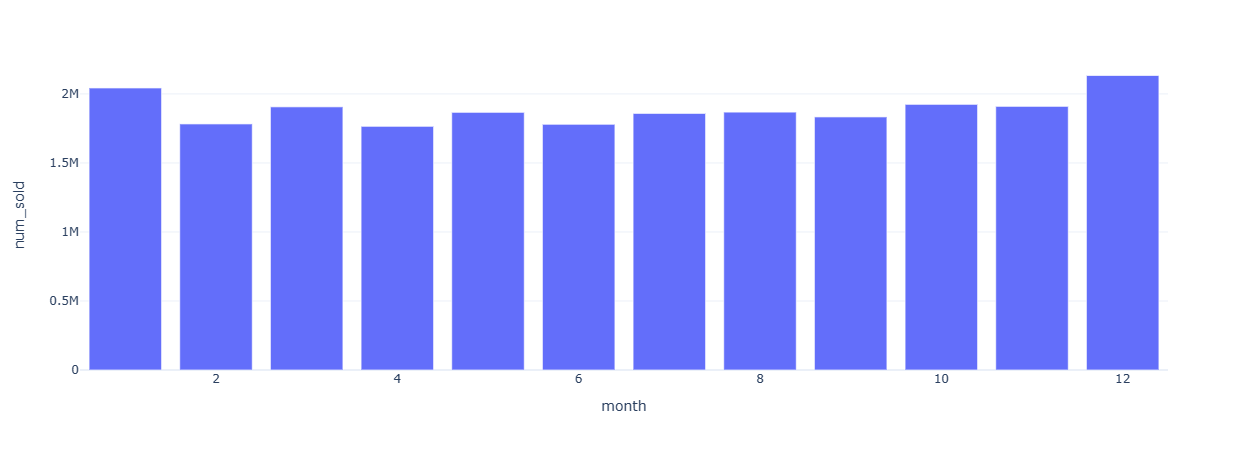

In [218]:
fig = px.bar(month_by_sold,x='month',y='num_sold')
fig.show()

In [219]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        136950 non-null  int64         
 1   date      136950 non-null  datetime64[ns]
 2   country   136950 non-null  object        
 3   store     136950 non-null  object        
 4   product   136950 non-null  object        
 5   num_sold  136950 non-null  int64         
 6   year      136950 non-null  int64         
 7   month     136950 non-null  int64         
 8   day       136950 non-null  int64         
 9   quarter   136950 non-null  int64         
 10  weekday   136950 non-null  int64         
dtypes: datetime64[ns](1), int64(7), object(3)
memory usage: 11.5+ MB


In [220]:
def train_cifar(config):
    net = Net(config["l1"], config["l2"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            net = torch.nn.DataParallel(net)
    net.to(device)

    criterion = torch.nn.MSELoss()
    optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)

    # To restore a checkpoint, use `session.get_checkpoint()`.
    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
           model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)

    
    trainset = ###
    testset = ###

    test_abs = int(len(trainset) * 0.8)
    train_subset, val_subset = random_split(
        trainset, [test_abs, len(trainset) - test_abs])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(10):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 2000 == 1999:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for i, data in enumerate(valloader, 0):
            with torch.no_grad():
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        # Here we save a checkpoint. It is automatically registered with
        # Ray Tune and can be accessed through `session.get_checkpoint()`
        # API in future iterations.
        os.makedirs("/kaggle/working/my_model", exist_ok=True)
        torch.save(
            (net.state_dict(), optimizer.state_dict()), "/kaggle/working/my_model/checkpoint.pt")
        checkpoint = Checkpoint.from_directory("my_model")
        session.report({"loss": (val_loss / val_steps), "accuracy": correct / total}, checkpoint=checkpoint)
    print("Finished Training")

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3241 in run_cell_async  │
│                                                                                                  │
│   3238 │   │   │   with self.display_trap:                                                       │
│   3239 │   │   │   │   # Compile to bytecode                                                     │
│   3240 │   │   │   │   try:                                                                      │
│ ❱ 3241 │   │   │   │   │   code_ast = compiler.ast_parse(cell, filename=cell_name)               │
│   3242 │   │   │   │   except self.custom_exceptions as e:                                       │
│   3243 │   │   │   │   │   etype, value, tb = sys.exc_info()                                     │
│   3244 │   │   │   │   │   self.CustomTB(etype, value, tb)                                       │
│                                                                                                  │
│ /opt/conda/lib/python3.10/site-packages/IPython/core/compilerop.py:86 in ast_parse               │
│                                                                                                  │
│    83 │   │                                                                                      │
│    84 │   │   Arguments are exactly the same as ast.parse (in the standard library),             │
│    85 │   │   and are passed to the built-in compile function."""                                │
│ ❱  86 │   │   return compile(source, filename, symbol, self.flags | PyCF_ONLY_AST, 1)            │
│    87 │                                                                                          │
│    88 │   def reset_compiler_flags(self):                                                        │
│    89 │   │   """Reset compiler flags to default state."""                                       │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
╭──────────────────────────────────────────────────────────────────────────────────────────────────╮
│     trainset = ###                                                                               │
│                ▲                                                                                 │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
SyntaxError: invalid syntax

In [ ]:
def test_best_model(best_result):
    best_trained_model = Net(best_result.config["l1"], best_result.config["l2"])
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    trainset, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    print("Best trial test set accuracy: {}".format(correct / total))

In [ ]:
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16]),
}

In [ ]:
def main(num_samples=10, max_num_epochs=10, gpus_per_trial=2):
    config = {
        "l1": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "l2": tune.sample_from(lambda _: 2 ** np.random.randint(2, 9)),
        "lr": tune.loguniform(1e-4, 1e-1),
        "batch_size": tune.choice([2, 4, 8, 16])
    }
    scheduler = ASHAScheduler(
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)
    
    tuner = tune.Tuner(
        tune.with_resources(
            tune.with_parameters(train_cifar),
            resources={"cpu": 2, "gpu": gpus_per_trial}
        ),
        tune_config=tune.TuneConfig(
            metric="loss",
            mode="min",
            scheduler=scheduler,
            num_samples=num_samples,
        ),
        param_space=config,
    )
    results = tuner.fit()
    
    best_result = results.get_best_result("loss", "min")

    print("Best trial config: {}".format(best_result.config))
    print("Best trial final validation loss: {}".format(
        best_result.metrics["loss"]))
    print("Best trial final validation accuracy: {}".format(
        best_result.metrics["accuracy"]))

    test_best_model(best_result)

main(num_samples=2, max_num_epochs=2, gpus_per_trial=0)